# Contents

* Data seems good to predict the different classes.
* Probability distributions seems to discern a bit. 
* There are some small overlapings could be due to the number of topics chosen 

# Setup

In [3]:
import re
from collections import Counter
import pandas as pd
import numpy as np
import gensim
from gensim.models.ldamulticore import LdaMulticore
import nltk
import matplotlib.pyplot as plt

# Raw dataset

In [4]:
data = pd.read_csv('../../data/raw/tweets-train.csv')

In [5]:
data.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [6]:
data = data.dropna().reset_index()

In [7]:
data.isnull().sum()

index            0
textID           0
text             0
selected_text    0
sentiment        0
dtype: int64

## 1. Tokenizing text

In [8]:
special_word = 'tweeety'

def remove_ascii_words(df, column):
    """ removes non-ascii characters from the 'texts' column in df.
    It returns the words containig non-ascii characers.
    """
    non_ascii_words = []
    indx_words = []
    for i in range(len(df)):
        for word in df.iloc[i][column].split(' '):
            if any([ord(character) >= 128 for character in word]):
                non_ascii_words.append(word)
                indx_words.append(i)
                df.loc[i, column] = df.loc[i, column].replace(word, special_word)
    return non_ascii_words, indx_words

non_ascii_words, indx_words = remove_ascii_words(data, 'text')

print("Replaced {} words with characters with an ordinal >= 128 in the train data.".format(
    len(non_ascii_words)))

Replaced 210 words with characters with an ordinal >= 128 in the train data.


In [9]:
def get_good_tokens(sentence):
    replaced_punctation = list(map(lambda token: re.sub('[^0-9A-Za-z!?]+', '', token), sentence))
    removed_punctation = list(filter(lambda token: token, replaced_punctation))
    return removed_punctation

def w2v_preprocessing(df):
    """ All the preprocessing steps for word2vec are done in this function.
    All mutations are done on the dataframe itself. So this function returns
    nothing.
    """
    df['text'] = df.text.str.lower()
    df['document_sentences'] = df.text.str.split('.')  # split texts into individual sentences
    df['tokenized_sentences'] = list(map(lambda sentences:
                                         list(map(nltk.word_tokenize, sentences)),
                                         df.document_sentences))  # tokenize sentences
    df['tokenized_sentences'] = list(map(lambda sentences:
                                         list(map(get_good_tokens, sentences)),
                                         df.tokenized_sentences))  # remove unwanted characters
    df['tokenized_sentences'] = list(map(lambda sentences:
                                         list(filter(lambda lst: lst, sentences)),
                                         df.tokenized_sentences))  # remove empty lists

w2v_preprocessing(data)


In [10]:
def lda_get_good_tokens(df):
    df['tokenized_text'] = list(map(nltk.word_tokenize, df.text))
    df['tokenized_text'] = list(map(get_good_tokens, df.tokenized_text))

lda_get_good_tokens(data)

In [11]:
def remove_stopwords(df):
    """ Removes stopwords based on a known set of stopwords
    available in the nltk package. 
    """
    stopwords = nltk.corpus.stopwords.words('english')+['tweeety']
    stopwords.append(special_word)

    df['stopwords_removed'] = list(map(lambda doc:
                                       [word for word in doc if word not in stopwords],
                                       df['tokenized_text']))

remove_stopwords(data)

In [12]:
def stem_words(df):
    lemm = nltk.stem.WordNetLemmatizer()
    df['lemmatized_text'] = list(map(lambda sentence:
                                     list(map(lemm.lemmatize, sentence)),
                                     df.stopwords_removed))

    p_stemmer = nltk.stem.porter.PorterStemmer()
    df['stemmed_text'] = list(map(lambda sentence:
                                  list(map(p_stemmer.stem, sentence)),
                                  df.lemmatized_text))

stem_words(data)

## Vectorize words

In [13]:
dictionary = gensim.corpora.Dictionary(data['stemmed_text'])
print(dictionary)

Dictionary(22016 unique tokens: ['go', 'respond', '!', 'diego', 'miss']...)


In [14]:
dictionary.filter_extremes(no_above=0.8, no_below=3)
dictionary.compactify()  # Reindexes the remaining words after filtering
print("Left with {} words.".format(len(dictionary.values())))

Left with 5655 words.


In [15]:
#Make a BOW for every document
def document_to_bow(df):
    df['bow'] = list(map(lambda doc: dictionary.doc2bow(doc), df.stemmed_text))
    
document_to_bow(data)

## LDA (training)

In [26]:
%%time
num_topics = 100
#A multicore approach to decrease training time
LDAmodel = LdaMulticore(corpus=data.bow,
                        id2word=dictionary,
                        num_topics=num_topics,
                        workers=4,
                        chunksize=2000,
                        passes=7,
                        alpha='asymmetric')

Wall time: 1min 25s


# LDA topic inspection

In [27]:
def document_to_lda_features(lda_model, document):
    """ Transforms a bag of words document to features.
    It returns the proportion of how much each topic was
    present in the document.
    """
    topic_importances = LDAmodel.get_document_topics(document, minimum_probability=0)
    topic_importances = np.array(topic_importances)
    return topic_importances[:,1]

data['lda_features'] = list(map(
    lambda doc: document_to_lda_features(LDAmodel, doc),
    data.bow))

## Topics distribution

In [28]:
pos_topic_distribution = data.loc[data.sentiment == 'positive', 'lda_features'].mean()
neg_topic_distribution = data.loc[data.sentiment == 'negative', 'lda_features'].mean()
neu_topic_distribution = data.loc[data.sentiment == 'neutral', 'lda_features'].mean()

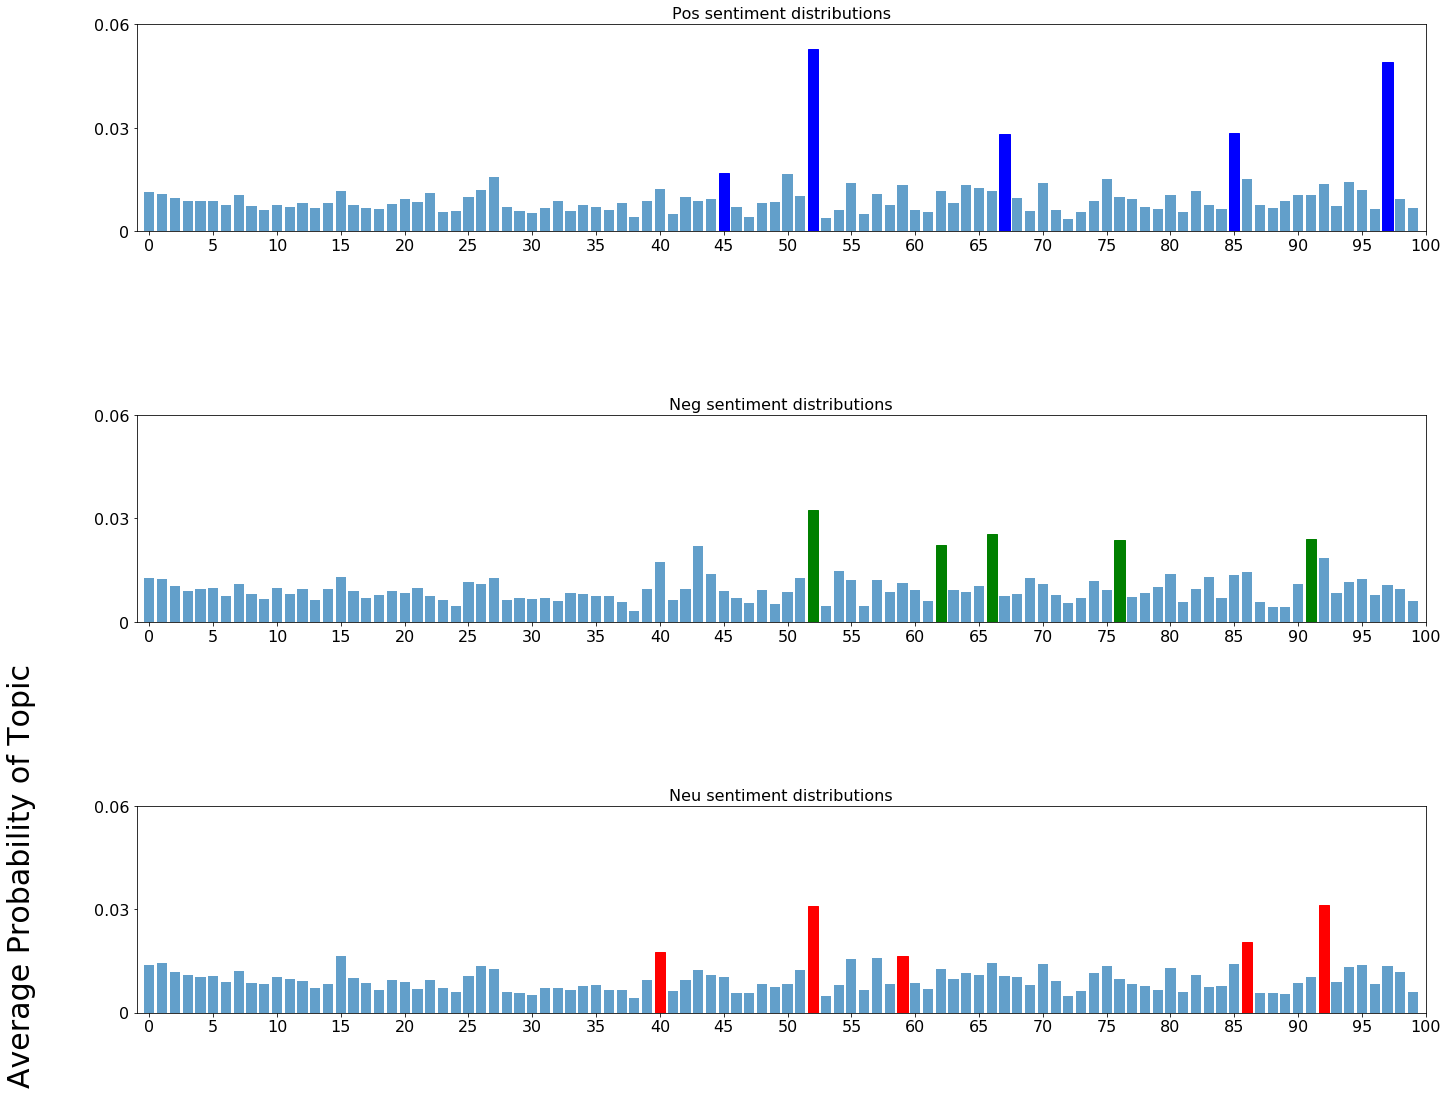

In [34]:
fig, [ax1,ax2,ax3] = plt.subplots(3,1,figsize=(20,15))

nr_top_bars = 5

ax1.set_title("Pos sentiment distributions", fontsize=16)
ax2.set_title("Neg sentiment distributions", fontsize=16)
ax3.set_title("Neu sentiment distributions", fontsize=16)
ax3.text(-10, 0.04, "Average Probability of Topic", fontsize=30, ha="center", va="center",
         rotation="vertical")

for ax, distribution, color in zip([ax1,ax2,ax3],
                                   [pos_topic_distribution,neg_topic_distribution,neu_topic_distribution],
                                   ['b','g','r']):
    # Individual distribution barplots
    ax.bar(range(len(distribution)), distribution, alpha=0.7)
    rects = ax.patches
    for i in np.argsort(distribution)[-nr_top_bars:]:
        rects[i].set_color(color)
        rects[i].set_alpha(1)
    # General plotting adjustments
    ax.set_xlim(-1, 50)
    ax.set_xticks(range(0,101,5))
    ax.set_xticklabels(range(0,101,5), fontsize=16)
    ax.set_ylim(0,0.06)
    ax.set_yticks([0,0.03,0.06])
    ax.set_yticklabels([0,0.03,0.06], fontsize=16)

fig.tight_layout(h_pad=3.)